## Aviso and Nino34 Correlation

<div class="alert alert-block alert-info">
Import Necessary Modules
</div>

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

<div class="alert alert-block alert-info">
Importing Index and Data
</div>

In [2]:
# Nino34 Index
file_nino34='/scratch/kpegion/nino34_1982-2019.oisstv2_anoms.nc'
ds_nino34=xr.open_dataset(file_nino34)
ds_nino34

<xarray.Dataset>
Dimensions:  (time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
    month    (time) int64 ...
Data variables:
    sst      (time) float32 ...

In [3]:
# Aviso Data
ds_aviso = xr.open_dataset('monthly_aviso.nc')
ds_aviso

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, time: 276)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
Data variables:
    sla        (time, latitude, longitude) float64 ...

### Prepare Data for Analysis

In [4]:
# Slice Nino34 to match Aviso data
ds_nino34=ds_nino34.sel(time=slice(ds_aviso['time'][0],ds_aviso['time'][-1]))
ds_nino34

<xarray.Dataset>
Dimensions:  (time: 276)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 0.1387 0.2251 0.4108 0.7553 ... 2.416 2.855 2.737

In [5]:
# Make anomalies
ds_climo=ds_aviso.groupby('time.month').mean()
ds_anoms=ds_aviso.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, time: 276)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2015-12-01
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sla        (time, latitude, longitude) float64 -0.01249 -0.01437 ... nan nan

### Calculate Correlation

In [6]:
r_map=xr.corr(ds_nino34['sst'],ds_anoms['sla'],dim='time')
r_map

<xarray.DataArray (latitude: 121, longitude: 1440)>
array([[0.15964212, 0.15673262, 0.14895011, ..., 0.13037464, 0.14495923,
        0.15579192],
       [0.14561888, 0.14488946, 0.14005125, ..., 0.11778186, 0.13044687,
        0.14073502],
       [0.12761474, 0.13057162, 0.12986001, ..., 0.10291708, 0.11170782,
        0.12078439],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12

<div class="alert alert-block alert-info">
Plot Correlation Map
</div>

Text(0.5, 1.0, 'Correlation between Nino3.4 and AVISO SLA Anomalies')

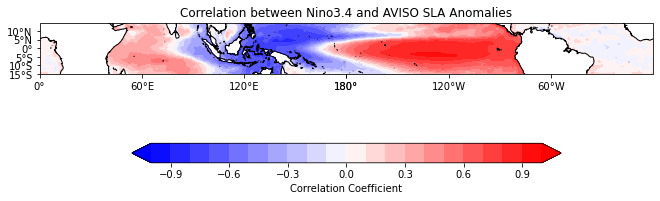

In [19]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_map
data,lon=add_cyclic_point(r_map,coord=ds_anoms['longitude'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['latitude'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines (If desired)
#ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(-15,15,5),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Nino3.4 and AVISO SLA Anomalies')

#### Calculate Correlation Significance

In [20]:
from scipy.stats import pearsonr

In [26]:

nx=len(ds_anoms['longitude'])
ny=len(ds_anoms['latitude'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r,p=pearsonr(ds_nino34['sst'],ds_anoms['sla'][:,j,i])
        r_array[j,i]=r
        p_array[j,i]=p
r_array.shape

ValueError: array must not contain infs or NaNs